# YOLOv8 Deployment & Inference
**Project:** PPE Detection (Object Detection)

This notebook handles the deployment of the trained model to a real-time endpoint.
It supports two sources for the model artifact:
1. **Local Training:** Uses the `.pt` file uploaded manually to S3.
2. **SageMaker Job:** Uses the artifact generated by a cloud training job.

In [ ]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch

boto_session = boto3.Session(profile_name='pessoal', region_name='us-east-1')
bucket_name = 'sagemaker-portfolio-cv-aws' 
sess = sagemaker.Session(boto_session=boto_session, default_bucket=bucket_name)
region = sess.boto_region_name

print(f"Region: {region}")
print(f"Target bucket: {bucket_name}")

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\josel\AppData\Local\sagemaker\sagemaker\config.yaml
Região: us-east-1
Bucket alvo: sagemaker-portfolio-cv-aws


In [14]:
import sys
sys.path.append(os.path.abspath(".."))
from config_private import IAM_ROLE
role = IAM_ROLE

In [8]:
# choose 'local' to use the artifact from local training
SOURCE_TYPE = 'local' 
TRAINING_JOB_NAME = 'pytorch-training-2025-11-26-17-54-10-326'
MODEL_ARTIFACT_PATH = 's3://sagemaker-portfolio-cv-aws/models/ppe/yolo_v1/model.tar.gz'

if SOURCE_TYPE == 'local':
    model_data = MODEL_ARTIFACT_PATH
    print(f"Usando artefato de TREINO LOCAL: {model_data}")

elif SOURCE_TYPE == 'job':
    # Busca o artefato direto dos metadados do Job
    client = boto_session.client('sagemaker')
    desc = client.describe_training_job(TrainingJobName=TRAINING_JOB_NAME)
    model_data = desc['ModelArtifacts']['S3ModelArtifacts']
    print(f"Usando artefato do SAGEMAKER JOB: {model_data}")

else:
    raise ValueError("SOURCE_TYPE deve ser 'local' ou 'job'")

Usando artefato de TREINO LOCAL: s3://sagemaker-portfolio-cv-aws/models/ppe/yolo_v1/model.tar.gz


In [9]:
from sagemaker.pytorch import PyTorchModel
model = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point='inference_yolo.py', 
    source_dir='../../sagemaker_entry_point/ppe', 
    framework_version='2.6.0', # does not support 2.8 yet
    py_version='py312',
    sagemaker_session=sess
)

print("Model setup complete. Ready to deploy.")

Model setup complete. Ready to deploy.


In [10]:
# Nome único para o endpoint
import time
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import IdentitySerializer

endpoint_name = f'yolo-ppe-endpoint-{int(time.time())}'

print(f"Deploying: {endpoint_name}")

predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name,
    serializer=IdentitySerializer(content_type='application/x-image'),
    deserializer=JSONDeserializer()
)

print("Endpoint Ativo!")

Deploying: yolo-ppe-endpoint-1764183122
---------------!Endpoint Ativo!


## Testing

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import io
import glob
import os

def visualize_detection(image_path, prediction):
    im = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im)
    
    colors = ['red', 'green', 'blue', 'yellow', 'cyan']
    
    for det in prediction:
        box = det['box'] # [x1, y1, x2, y2]
        conf = det['confidence']
        cls_name = det['class_name']
        cls_id = det['class_id']
        
        width = box[2] - box[0]
        height = box[3] - box[1]
        
        rect = patches.Rectangle(
            (box[0], box[1]), width, height, 
            linewidth=2, 
            edgecolor=colors[cls_id % len(colors)], 
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Label
        label_text = f"{cls_name} {conf:.2f}"
        plt.text(
            box[0], box[1]-5, label_text, 
            color='white', fontsize=10, weight='bold',
            bbox=dict(facecolor=colors[cls_id % len(colors)], alpha=0.5)
        )
        
    plt.axis('off')
    plt.show()

Testando na imagem: f:\Pessoal\aws-sagemaker-cv-pipeline\data\raw\ppe\valid\images\-1079-_png_jpg.rf.77459a818bed5a44927d46bdb976c661.jpg


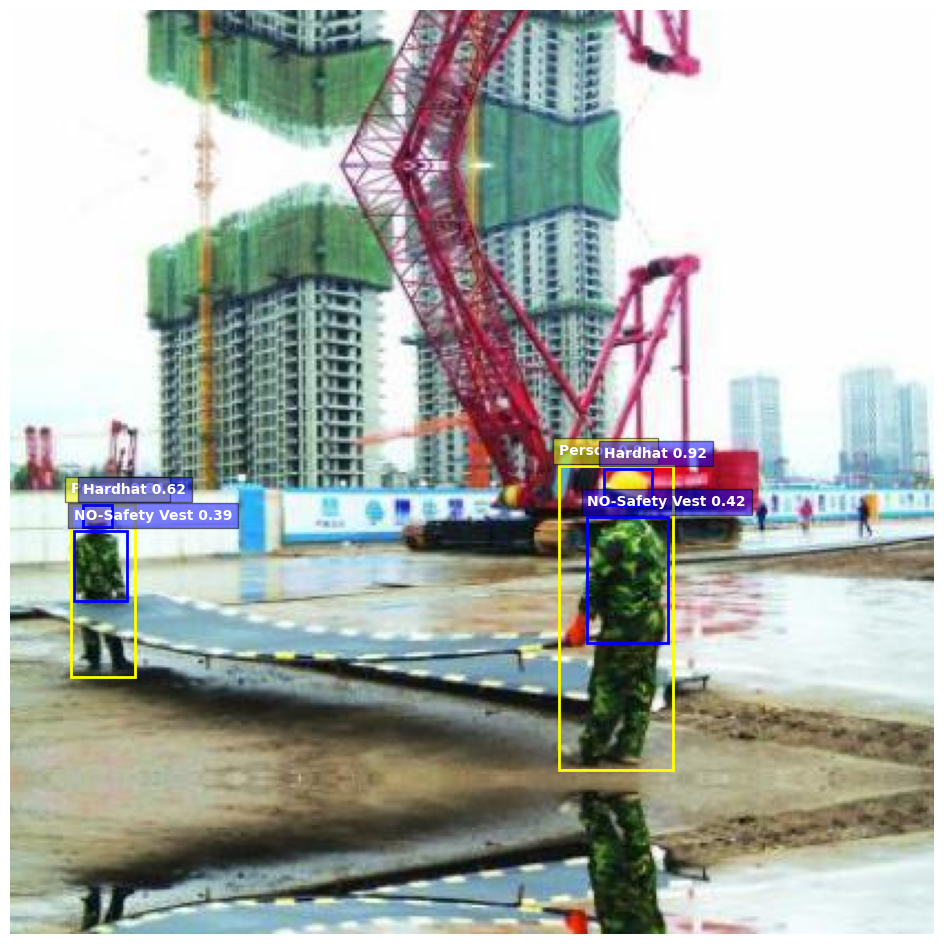

In [ ]:
dataset_root = os.path.abspath('../../data/raw/ppe')
val_images = glob.glob(os.path.join(dataset_root, 'valid', 'images', '*.jpg'))

if val_images:
    test_img = val_images[0]
    print(f"Testando na imagem: {test_img}")
    
    with open(test_img, 'rb') as f:
        payload = f.read()
        
    # Invocação
    response = predictor.predict(payload)
    
    # Visualização
    visualize_detection(test_img, response)
else:
    print("Nenhuma imagem de validação encontrada para testar.")

## Shutting down endpoint

In [13]:
predictor.delete_endpoint()
print("Shutting down endpoint...")

Shutting down endpoint...
